# Healthcare Facility Location - Organ Transplant Centers

## Chhean Quentin

The organ transplantation centers' optimization problem is a problem where we will optimize a network of OTC, hospitals and organ recipient locations.<br>
We have 3 distinctive features for an organ transplant : <br>
- Organ transplant suffer from long waiting lists.
- The time elapsed between donor notification and transplantation is very important
- To transplant an organ, we need both a donor (who is an hospital) and a recipient (who is at its location) and we need both to go to the OTC to perform the transplant.

## Creating the graph

In [1]:
#Importing the librairies

import networkx as nx
import numpy as np
import random as rand
import gurobipy as gb
import os
import matplotlib.pyplot as plt

In [2]:
#Drawing function

def DrawInitG(G, figure_size, withedges=False):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]
    
    
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6, fontsize=8,\
                           shape='circle', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'dist').get('dist') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, figure_size, x):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]

    
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6, fontsize=8,\
                           shape='circle', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    
    nx.draw_networkx_edges(G,pos=pos, edgelist = x, alpha=1.0)
    
        
    
    plt.axis('off')
    plt.show()

In [3]:
#Setting the network values

number_of_hospitals = 5
number_of_OTC = 20
number_of_recpoints = 5

area_size = 10

#Number of candidate OTC's to be established
p = 20

#Maximum acceptable distance between a OTC and a organ recipient point
T = 15

#Maximum size of an OTC
E = 5

In [4]:
#Creating a random network and removing all edges

G = nx.complete_graph(number_of_hospitals + number_of_OTC + number_of_recpoints)
G = nx.create_empty_copy(G)
pos = nx.random_layout(G)

In [5]:
#Changing the size of the network

for i in range(len(pos.values())) :
    pos[i] = pos[i]*area_size

In [6]:
#Assinging the pos values to the x and y attribute of each node

for i in range(len(G)):
    G.nodes[i]["x"] = pos[i][0]
    G.nodes[i]["y"] = pos[i][1]

In [7]:
#Assining what type of location a node is and its color
#For recipint points, we give the variable w which is the demand size at organ recipient point


for i in range(len(G)):
    if i >= 0 and i < number_of_hospitals:
        G.nodes[i]['color'] = "blue"
        G.nodes[i]['location_type'] = "hospital"
    elif i >= number_of_hospitals and i < number_of_OTC + number_of_hospitals:
        G.nodes[i]['color'] = "red"
        G.nodes[i]['location_type'] = "OTC"
    else:
        G.nodes[i]['color'] = "green"
        G.nodes[i]['location_type'] = "recpoint"
        G.nodes[i]['w'] = rand.randint(1,E)

In [8]:
#Creating the edges that are only useful, e.g the ones between OTC and hospitals and OTC and recipient location
#Adding the cost (e.g distance) and naming it a or t accordingly to the pdf.

index_of_OTC = list(range(number_of_hospitals, number_of_hospitals + number_of_OTC))
index_of_hospitals = list(range(0,number_of_hospitals))
index_of_recpoints = list(range(number_of_hospitals + number_of_OTC, number_of_hospitals + number_of_OTC + number_of_recpoints))

for source in index_of_OTC:
    for target in index_of_hospitals:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,a=distance, dist=distance)
        
for source in index_of_OTC:
    for target in index_of_recpoints:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,t=distance, dist=distance)
    

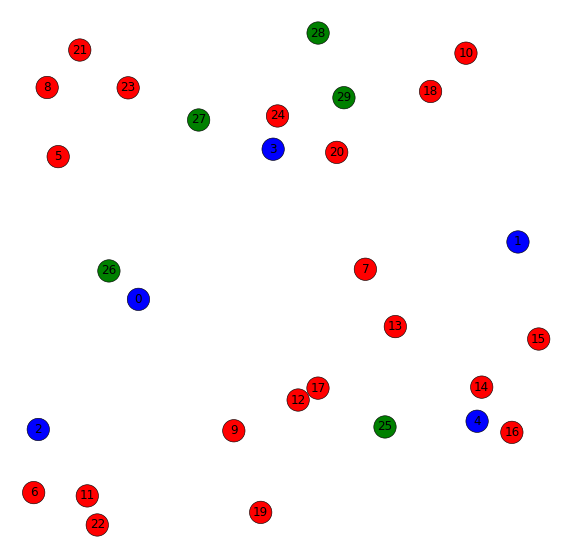

In [9]:
DrawInitG(G,(10,10), withedges=False)

In [10]:
#Keeping only the OTCs that are at an acceptable travel time T, e.g deleting the edges from recipient point to OTC which distance is grater than T

for source in index_of_OTC:
    for target in index_of_recpoints:
        if G[source][target]["dist"] > T:
            G.remove_edge(source,target)

C:\Users\Quentin\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


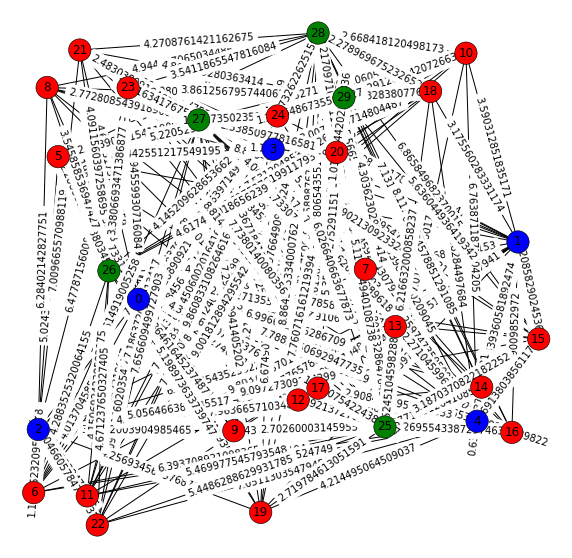

In [11]:
DrawInitG(G,(10,10), withedges=True)

## Optimizing the model

Now that we have created our graph representing the locations of recipients, hospitals and OTC, we have to optimize the model according to the paper's constraints

In [12]:
#Creating the model
model = gb.Model()

#Variable decision z, z[j] = 1 if OTC at location j is active
z = model.addVars(index_of_OTC, vtype=gb.GRB.BINARY, name='z')

#Variable decision x, x[i][j] = 1 if hospital i serves an OTC in location j
x = model.addVars([(j, i) for i in index_of_hospitals for j in index_of_OTC],
                 obj=[G[j][i]['a'] for i in index_of_hospitals for j in index_of_OTC],
                 vtype=gb.GRB.BINARY, name='x')

#Variable decision y, y[i][j] = 1 if recipient point i is served by an OTC in location j
y = model.addVars([(j, i) for i in index_of_recpoints for j in index_of_OTC],
                 obj=[G[j][i]['dist'] for i in index_of_recpoints for j in index_of_OTC],
                 vtype=gb.GRB.BINARY, name='y')

Using license file C:\Users\Quentin\gurobi.lic
Academic license - for non-commercial use only


In [13]:
# Adding constraints

#Constr. 40 and 41 : Each recipeint and hospital has only one assigned OTC
model.addConstrs((x.sum('*',i) == 1 for i in index_of_hospitals), name='40')
model.update()
model.addConstrs((y.sum('*',i) == 1 for i in index_of_recpoints), name='41')
model.update()

In [14]:
#Constr. 42 : Establishes p as the maximum number of active OTC
model.addConstrs((z.sum(j) <= p for j in index_of_OTC), name='42')
model.update()

In [15]:
#Constr. 43 and 44 : Limiting assignment to active OTC, only active OTCs can be assigned
model.addConstrs((y[j,k] <= z[j] for k in index_of_recpoints for j in index_of_OTC), name='43')
model.update()
model.addConstrs((x[j,i] <= z[j] for i in index_of_hospitals for j in index_of_OTC), name='44')
model.update()

In [16]:
#Constr. 45 : Maximum size of waiting list of actives OTCs
model.addConstrs((E>=gb.quicksum(y[j,k]*G.nodes[k]["w"] for k in index_of_recpoints) for j in index_of_OTC), name='45')
model.update()

In [17]:
model.optimize()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 250 rows, 220 columns and 720 nonzeros
Model fingerprint: 0xa85e206b
Variable types: 0 continuous, 220 integer (220 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [6e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 56.1869821
Presolve removed 225 rows and 120 columns
Presolve time: 0.00s
Presolved: 25 rows, 100 columns, 200 nonzeros
Found heuristic solution: objective 20.8733682
Variable types: 0 continuous, 100 integer (100 binary)

Root relaxation: objective 1.495795e+01, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      14.9579466   14.95795  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 ava

In [18]:
#Creating xfinal, the dict of all active edges

xfinal = dict(x)
xfinal.update(y)

#Removing the key from the dict if the value is 0, e.G the edge isn't active
for xtuple in list(xfinal) :
    if xfinal[xtuple].x != 1 :
        xfinal.pop(xtuple, None)

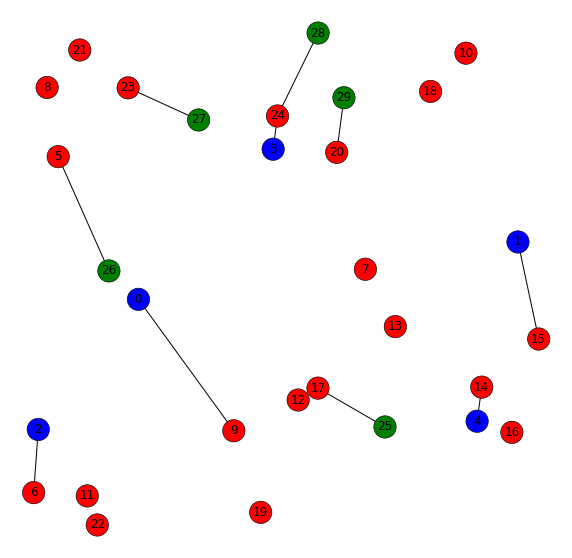

In [19]:
DrawSol(G, (10,10), xfinal)

## Going beyond the problem

As we can see, we modelized the problem and optimized it accordingly to the paper's constraints : every hospital in blue and recipient point in green is now linked to the nearest OTC in red depending on the recipient's location's demand. <br>
However, one critical aspect wasn't taken account on this paper : some OTC are linked only to a hospital and vice-versa. <br>
One improvement that we could make on the paper's modelisation is creating a constraint saying that an OTC have to be linked to both a hospital and a recipient location, as organ transplant needs both a donor and a recipient but creating such a constraint could create a model which has no feasible solution. <br>